##### **1.** 
Write a program that reads the trajectory file.

The columns represent the dimensions. As you will see, you will be working with a two-dimensional system.

In [923]:
import numpy as np

file = open("traj-2.txt", "r")
lines = file.readlines()
file.close()

x = []
y = []
for line in lines:
    x.append(float(line.split()[0]))
    y.append(float(line.split()[1]))


data = np.array([x, y]).T

#### **2.**
Discretize the trajectory into 100 clusters to create a one-dimensional discrete trajectory.

You may use common libraries (such as SciPy/Numpy). 

In [924]:
from scipy.cluster.vq import kmeans2

np.random.seed(0)

default_num_clusters = 100

def state_clustering(num_clusters):

    _, states = kmeans2(data, num_clusters, minit='points')

    return states

default_states = state_clustering(default_num_clusters)

#### **3.**

Plot the trajectory itself as well as a 2D histogram.

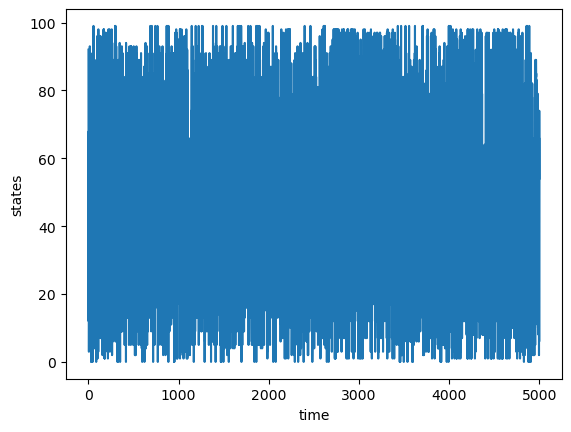

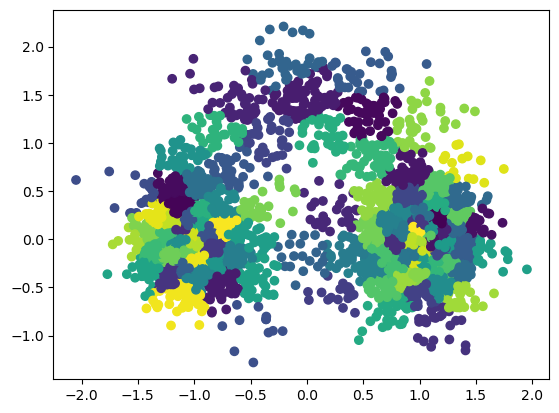

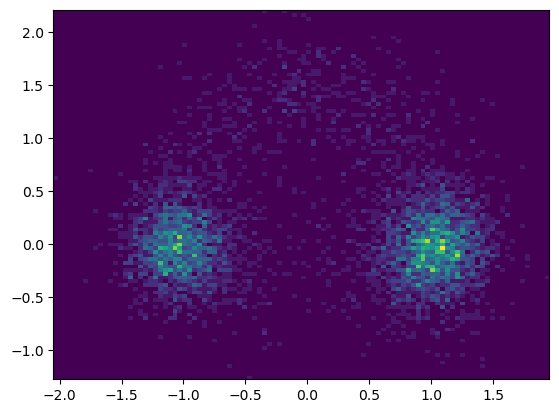

In [925]:
import matplotlib.pyplot as plt
#plot the labels. each point belongs to a cluster, plot the trajectory of each cluster. y axis is the cluster and x axis is the index of the label
def plot_trajectory_2dhist(states):
    plt.plot(states)
    plt.ylabel('states')
    plt.xlabel('time')
    plt.show()

    plt.scatter(x, y, c=states)
    plt.show()

    plt.hist2d(x, y, bins=100)
    plt.show()

plot_trajectory_2dhist(default_states)

## **TODO: COMMENT**

#### **4.**
Write a program that calculates the **count matrix** from the discretized trajectory.

That is, an `n x n` matrix that, in its ijth element, contains the number of transitions 

from i to j and where `n` is the number of states.

In [926]:
#count matrix for the transition probabilities between the clusters

def count_matrix(states, num_clusters):

    time_lag = 1

    count_matrix = np.zeros((num_clusters, num_clusters))

    for i in range(1, len(states), time_lag):
        current_cluster = states[i]
        previous_cluster = states[i-1]
        count_matrix[previous_cluster][current_cluster] += 1

    return count_matrix

default_count_matrix = count_matrix(default_states, default_num_clusters)

#### **5.**
Based on the count matrix, calculate the **transition matrix**.

That is, an `n x n` matrix that, in its ijth element, contains the transition probability from i to j

Note that the rows sum to one! You may use the trivial estimator described in the lecture 

slides to calculate the transition matrix.

In [927]:
def transition_matrix(count_matrix, num_clusters):

    transition_matrix = np.zeros((num_clusters, num_clusters))

    for i in range(num_clusters):
        row_sum = sum(count_matrix[i])
        for j in range(num_clusters):
            if row_sum != 0:
                transition_matrix[i][j] = count_matrix[i][j] / row_sum


    transition_matrix = np.nan_to_num(transition_matrix)

    return transition_matrix

default_transition_matrix = transition_matrix(default_count_matrix, default_num_clusters)

#### **6.**
Make comments about what you can say so far about the underlying dynamical system

that this trajectory stems from (e.g., how many macrostates do you observe?

Can you guess which transition is the slowest?)


##### **`Number of macrostates`**

Macrostates are characterized by groups of clusters, which correspond to the microstates, that have high intra-group 

transition probabilities and lower inter-group transitions.

- Firstly, we need to identify clusters that frequently transition between each other by analyzing the transition
  
   matrix. These are considered to be part of a macrostate.
  
- Secondly, we need to apply a threshold which will indicate us what probabilities we consider significant. Values 
  
  above the threshold will be considered as part of a macrostate.

- Thirdly, we are analysing the graph. A graph will be built where the nodes correspond to the clusters and the weights 
  
  of the edges correspond to the transition probabilities. The graph will be partitioned into communities by utilizing 
  
  graph theory. The communities will be considered as macrostates. We group the more densely connected nodes together, 
  
  have higher chances of transitioning among each other, and less connected to nodes outside their group.


**The number of macrostates is 2.**

##### **`Slowest transition`**

To find the slowest transition we will:

- Go through all the transitions between clusters from different macrostates which are typically slower than 
  
  transitions within the same macrostate. 

- Find the transition with the lowest probability. The transition with the lowest probability is the slowest one.

- We will be cautious with the transition probabilities. We want to avoid transitions with zero probability. We will 
  
  use a theshold to avoid this.

**The slowest transition is from cluster 8 to cluster 27 with probability 0.0127.**

In [928]:
import networkx as nx
from networkx.algorithms import community

def calculate_macro_staes(transition_matrix, num_clusters):

    cluster_graph = nx.DiGraph()

    for i in range(num_clusters):
        cluster_graph.add_node(i)

    threshold = 0.01
    for i in range(num_clusters):
        for j in range(num_clusters):
            if transition_matrix[i][j] > threshold:
                cluster_graph.add_edge(i, j, weight=transition_matrix[i][j])

    communities = community.greedy_modularity_communities(cluster_graph)
    macrostates = []
    for c in communities:
        macrostate = []
        for node in c:
            macrostate.append(node)
        macrostates.append(macrostate)

    num_macrostates = len(macrostates)
    print("Number of macrostates: ", num_macrostates)
    for i in range(num_macrostates):
        print("Macrostate ", i+1, ": ", macrostates[i])

    return macrostates

default_macrostates = calculate_macro_staes(default_transition_matrix, default_num_clusters)


Number of macrostates:  2
Macrostate  1 :  [0, 2, 4, 5, 6, 8, 9, 10, 11, 13, 14, 16, 18, 19, 20, 21, 22, 28, 29, 32, 33, 34, 35, 37, 38, 39, 40, 41, 43, 44, 46, 48, 50, 53, 54, 56, 60, 61, 62, 65, 66, 69, 70, 71, 72, 73, 74, 75, 78, 81, 82, 83, 84, 85, 87, 89, 91, 93, 94, 99]
Macrostate  2 :  [1, 3, 7, 12, 15, 17, 23, 24, 25, 26, 27, 30, 31, 36, 42, 45, 47, 49, 51, 52, 55, 57, 58, 59, 63, 64, 67, 68, 76, 77, 79, 80, 86, 88, 90, 92, 95, 96, 97, 98]


In [929]:
def different_macrostates(c1, c2, macrostates):
        for macrostate in macrostates:
            if c1 in macrostate and c2 in macrostate:
                return False
        return True

def find_slowest_transition(macrostates, transition_matrix, num_clusters):
    threshold = 0.01
    slowest_trans = None
    lowest_prob = float('inf')

    for i in range(num_clusters):
        for j in range(num_clusters):
            if i != j and different_macrostates(i, j, macrostates):
                if transition_matrix[i][j] < lowest_prob:
                    if transition_matrix[i][j] < threshold:
                        continue
                    lowest_prob = transition_matrix[i][j]
                    slowest_trans = (i, j)

    print("Slowest Transition:", slowest_trans)
    print("Probability:", round(lowest_prob, 4))

find_slowest_transition(default_macrostates, default_transition_matrix, default_num_clusters)


Slowest Transition: (8, 27)
Probability: 0.0127


#### **7.**

Calculate the eigenvalues from the obtained transition matrix from T(τ). What can you say about the timescale of the 

slowest processes? Assume a lag time τ . You may use common software packages like numpy to do the eigendecomposition. 

It is possible that you get complex values for the eigenvalues/eigenvector. In that case you may discard the imaginary 

part. Note that you can easily convert the eigenvalues into timescales (check lecture notes for that).

In [930]:
def get_eigenvalues(transition_matrix):

    eigenvalues, eigenvectors = np.linalg.eig(transition_matrix)

    eigen_tuples = []

    for i in range(1, len(eigenvalues)):
        if eigenvalues[i].real > 0:
            eigen_tuples.append((i, eigenvalues[i].real, eigenvectors[:,i].real))
        
    eigen_tuples.sort(key=lambda x: x[1], reverse=True)

    for i in range(len(eigen_tuples)):
        print("Eigenvalue", eigen_tuples[i][0] + 1, ":", eigen_tuples[i][1])

    return eigen_tuples

default_eigen_tuples = get_eigenvalues(default_transition_matrix)

Eigenvalue 2 : 0.9880509815075704
Eigenvalue 3 : 0.8987969156989578
Eigenvalue 4 : 0.673866419482109
Eigenvalue 5 : 0.5810165378753325
Eigenvalue 6 : 0.5199811131364084
Eigenvalue 7 : 0.4861091443200603
Eigenvalue 8 : 0.4174791104712183
Eigenvalue 9 : 0.3831671139049548
Eigenvalue 10 : 0.3366764013317078
Eigenvalue 11 : 0.3366764013317078
Eigenvalue 12 : 0.30214181538109897
Eigenvalue 13 : 0.25751521642859554
Eigenvalue 14 : 0.24069222150503666
Eigenvalue 15 : 0.24069222150503666
Eigenvalue 16 : 0.19252159821698525
Eigenvalue 17 : 0.19252159821698525
Eigenvalue 18 : 0.1599049310464462
Eigenvalue 19 : 0.1599049310464462
Eigenvalue 20 : 0.15833598284957365
Eigenvalue 21 : 0.15833598284957365
Eigenvalue 39 : 0.13951538386911733
Eigenvalue 40 : 0.1290291326089315
Eigenvalue 41 : 0.1290291326089315
Eigenvalue 46 : 0.12131648526181618
Eigenvalue 51 : 0.10060830660692817
Eigenvalue 52 : 0.10060830660692817
Eigenvalue 47 : 0.09321847817530761
Eigenvalue 48 : 0.09321847817530761
Eigenvalue 42 :

The largest eigenvalue is 1 and represents the steady-state, and the magnitude of the second-largest eigenvalue 

indicates the timescale of the slowest process. This the rate at which the system transitions away from its slowest

process towards equilibrium.

Timescale 2 : 83.18788036868298
Timescale 3 : 9.372231947601929
Timescale 4 : 2.5334197434032153
Timescale 5 : 1.8417018305023822
Timescale 6 : 1.5291389921338792
Timescale 7 : 1.3863432094218149
Timescale 8 : 1.1447924691590414
Timescale 9 : 1.0424440951602139
Timescale 10 : 0.918583177384908
Timescale 11 : 0.918583177384908
Timescale 12 : 0.8355204581961239
Timescale 13 : 0.7370954120675725
Timescale 14 : 0.7021307029639816
Timescale 15 : 0.7021307029639816
Timescale 16 : 0.6069629823339906
Timescale 17 : 0.6069629823339906
Timescale 18 : 0.5455014125644246
Timescale 19 : 0.5455014125644246
Timescale 20 : 0.5425829900986313
Timescale 21 : 0.5425829900986313
Timescale 22 : 0.5077223541498659
Timescale 23 : 0.48834871605723756
Timescale 24 : 0.48834871605723756
Timescale 25 : 0.47407911577274664
Timescale 26 : 0.43544136444483283
Timescale 27 : 0.43544136444483283
Timescale 28 : 0.42144136674289157
Timescale 29 : 0.42144136674289157
Timescale 30 : 0.4210432489742266
Timescale 31 : 0.42

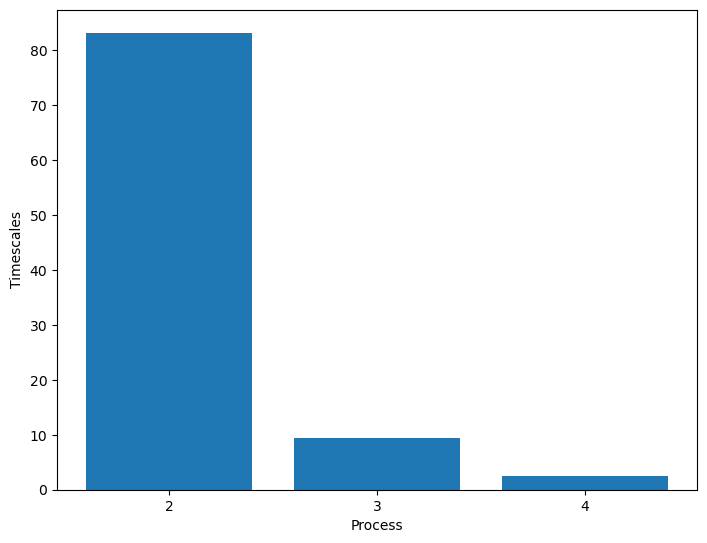

In [931]:
#calculate timesclaes for each tuple

def get_timescales(eigen_tuples, time_lag):
    timescales = []
    for i in range(len(eigen_tuples)):
        timescales.append((i+1, -time_lag / np.log(eigen_tuples[i][1])))
    timescales.sort(key=lambda x: x[1], reverse=True)

    for i in range(len(timescales)):
        print("Timescale", timescales[i][0] + 1, ":", timescales[i][1])

    if len(timescales) < 3:
        fig = plt.figure()
        ax = fig.add_axes([0, 0, 1, 1])
        plt.bar([2, 3], [timescales[0][1], timescales[1][1]])
        plt.ylabel('Timescales')
        plt.xlabel('Process')
        ax.set_xticks([2, 3])
        plt.show()
    else:
        fig = plt.figure()
        ax = fig.add_axes([0, 0, 1, 1])
        plt.bar([2, 3, 4], [timescales[0][1], timescales[1][1], timescales[2][1]])
        plt.ylabel('Timescales')
        plt.xlabel('Process')
        ax.set_xticks([2, 3, 4])
        plt.show()

    return timescales

default_timescales = get_timescales(default_eigen_tuples, 1)


From the observed plot, it is clear that there exists only one slow process. The timescale of the slowest process is around 80. The third 

process is approximately 10 and the fourth process is approximately 3. Using the eigenvectors, we see that the slowest process belongs to the 

transition between macrostates 1 and 2.

#### **8.**

Visualise the first few eigenfunctions of the system depending on how many slow processes you observed

(keyword: spectral gap). Describe what the eigenfunctions tell you about the system in question.

Your visualization may look something like this: `plt.scatter(*traj.T, c=eigvecs[i][dtraj])`

##### **`The spectral gap`**

- Significant difference in the magnitude of eigenvalues. 
  
- Helps in identifying how many slow processes are present in the system.
  
- For example, a large gap after the second largest eigenvalue suggests one primary slow process.


##### **`Eigenfunctions`**

- Eigenfunctions are the eigenvectors of the transition matrix.

- We are going to select, based on the spectral gap, the first few eigenfunctions of the system, which correspond to 
  
  the largest eigenvalues, exluding the first one which is always 1.

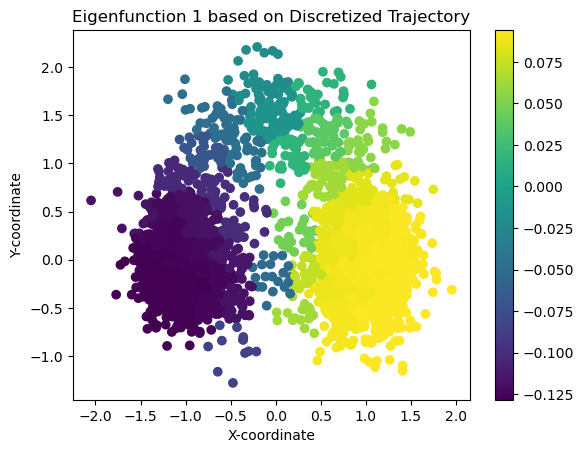

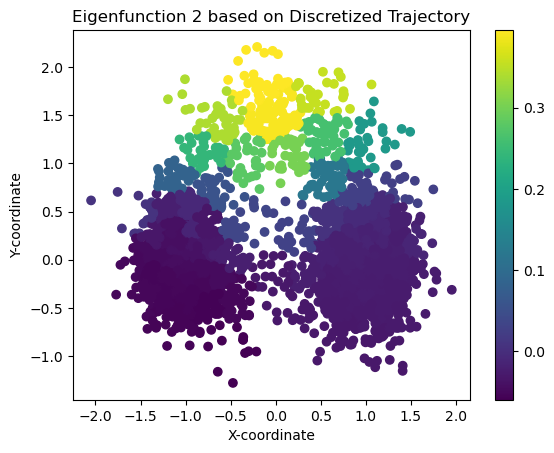

In [932]:
# Assuming 'eigvecs' are the eigenvectors and 'traj' is your trajectory data
# Replace 'num_eigfuncs_to_plot' with the number of slow processes identified


""" def plot_eigenfunctions(eigvecs, num_eigfuncs_to_plot):
    for i in range(num_eigfuncs_to_plot):
        plt.figure()
        plt.scatter(data[:, 0], data[:, 1], c=eigvecs[i])
        plt.title(f"Eigenfunction {i+1} based on Discretized Trajectory")
        plt.xlabel("X-coordinate")
        plt.ylabel("Y-coordinate")
        plt.colorbar()
        plt.show() """

num_eigenfunctions = 2  # For example, visualizing the first two eigenfunctions

eigenvectors = np.array([eigen_tuple[2] for eigen_tuple in default_eigen_tuples])

#trajectory with x and y coordinates
traj = np.array([x, y])

for i in range(num_eigenfunctions):
    plt.figure()
    plt.scatter(data[:, 0], data[:, 1], c=eigenvectors[i, default_states])
    plt.title(f"Eigenfunction {i+1} based on Discretized Trajectory")
    plt.xlabel("X-coordinate")
    plt.ylabel("Y-coordinate")
    plt.colorbar()
    plt.show()

##### **`9`**

Discretize the continuous trajectory again (trajectory file). This time in 

    3
    10
    100
    1000
states and visualize the leading eigenfunctions and timescales as a function of number of states (3, 10, 100, 1000). Comment on the quality of 

the discretization as the number of states increase. Also, do you see a difference in the estimated timescale of the slowest process as the 

number of states increases? Comment on why or why not you observe these differences

------------------
Discretization Value: 3
------------------



Number of macrostates:  2
Macrostate  1 :  [0, 2]
Macrostate  2 :  [1]
Slowest Transition: (1, 2)
Probability: 0.015
Eigenvalue 2 : 0.9999999999999999
Eigenvalue 3 : 0.9785564873460725
Timescale 2 : 9007199254740992.0
Timescale 3 : 46.132344287163356


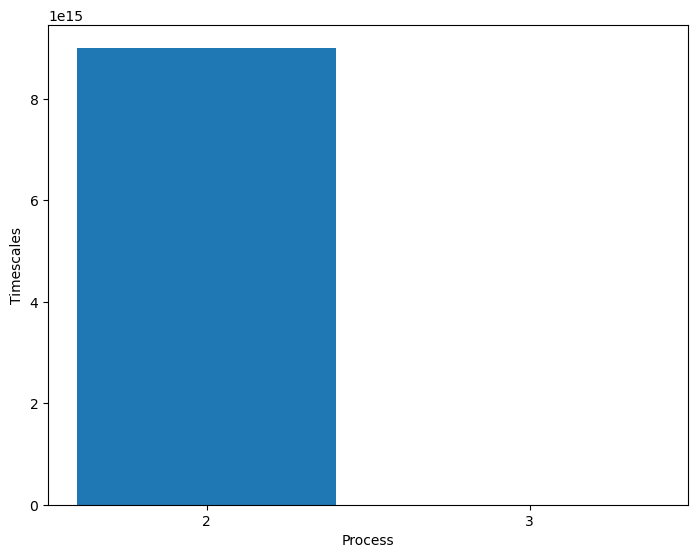

------------------
Discretization Value: 10
------------------





TypeError: 'numpy.ndarray' object is not callable

In [933]:
discretization_values = [3, 10, 100, 1000]

for discretization_value in discretization_values:
    print("------------------")
    print("Discretization Value:", discretization_value)
    print("------------------")
    print()
    print()
    print()
    num_clusters = discretization_value
    states = state_clustering(num_clusters)
    count_matrix = count_matrix(states, num_clusters)
    transition_matrix = transition_matrix(count_matrix, num_clusters)
    macrostates = calculate_macro_staes(transition_matrix, num_clusters)
    find_slowest_transition(macrostates, transition_matrix, num_clusters)
    eigen_tuples = get_eigenvalues(transition_matrix)
    timescales = get_timescales(eigen_tuples, 1)